In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn.objects as so

import pymc as pm
import arviz as az

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
df = pd.read_csv(pm.get_data("test_scores.csv"), index_col=0)
display(df)

,score,male,siblings,family_inv,non_english,prev_disab,age_test,non_severe_hl,mother_hs,early_ident,non_white
0,40,0,2.0,2.0,False,NaN,55,1.0,NaN,False,False
1,31,1,0.0,NaN,False,0.0,53,0.0,0.0,False,False
2,83,1,1.0,1.0,True,0.0,52,1.0,NaN,False,True
3,75,0,3.0,NaN,False,0.0,55,0.0,1.0,False,False
5,62,0,0.0,4.0,False,1.0,50,0.0,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...
220,68,0,2.0,2.0,False,0.0,53,0.0,1.0,True,False
221,104,1,2.0,0.0,False,0.0,52,1.0,1.0,False,False
222,71,1,1.0,NaN,False,0.0,57,1.0,NaN,False,True
223,118,0,2.0,0.0,False,0.0,57,1.0,NaN,True,False


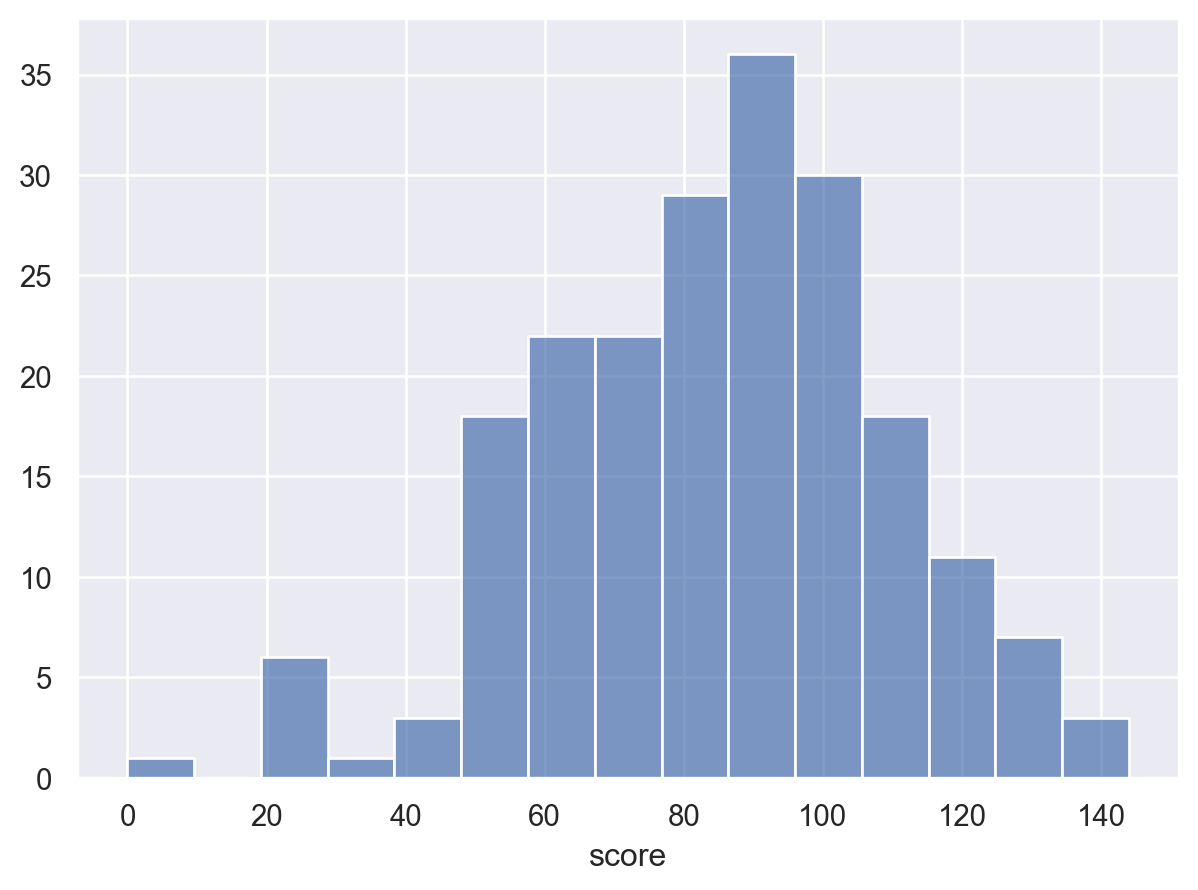

In [3]:
(
    so.Plot(df, x="score")
    .add(so.Bars(), so.Hist())
)

In [4]:
df.describe()

,score,male,siblings,family_inv,prev_disab,age_test,non_severe_hl,mother_hs
count,207.000000,207.000000,207.000000,174.000000,189.000000,207.000000,207.000000,134.000000
mean,84.193237,0.512077,1.125604,0.977011,0.238095,53.545894,0.415459,0.701493
std,24.885590,0.501066,0.866682,1.002621,0.427049,3.631920,0.493996,0.459320
min,0.000000,0.000000,0.000000,0.000000,0.000000,48.000000,0.000000,0.000000
25%,68.000000,0.000000,1.000000,0.000000,0.000000,50.000000,0.000000,0.000000
50%,87.000000,1.000000,1.000000,1.000000,0.000000,54.000000,0.000000,1.000000
75%,98.000000,1.000000,2.000000,2.000000,0.000000,57.000000,1.000000,1.000000
max,144.000000,1.000000,3.000000,4.000000,1.000000,59.000000,1.000000,1.000000


In [5]:
print(df.shape)
print(df.isnull().sum())

(207, 11)
score             0
male              0
siblings          0
family_inv       33
non_english       0
prev_disab       18
age_test          0
non_severe_hl     0
mother_hs        73
early_ident       0
non_white         0
dtype: int64


In [6]:
df1 = df.dropna().astype(float)
print(df1.shape)

(101, 11)


In [7]:
y = df1["score"]
X = df1.drop(["score"], axis=1)

display(X.head())

,male,siblings,family_inv,non_english,prev_disab,age_test,non_severe_hl,mother_hs,early_ident,non_white
7,0.0,2.0,3.0,1.0,1.0,50.0,1.0,1.0,0.0,1.0
12,1.0,1.0,0.0,0.0,0.0,48.0,1.0,1.0,1.0,0.0
14,0.0,2.0,0.0,0.0,0.0,58.0,1.0,1.0,1.0,1.0
19,1.0,0.0,2.0,0.0,0.0,50.0,1.0,1.0,0.0,1.0
21,1.0,1.0,2.0,0.0,1.0,58.0,0.0,0.0,1.0,1.0


In [8]:
X -= X.mean()
X /= X.std()

display(X.head())

,male,siblings,family_inv,non_english,prev_disab,age_test,non_severe_hl,mother_hs,early_ident,non_white
7,-1.004938,1.078165,2.227502,2.480475,1.782293,-0.978004,1.179344,0.616250,-0.772789,1.132532
12,0.985234,-0.080289,-0.911722,-0.399157,-0.555520,-1.562492,1.179344,0.616250,1.281203,-0.874235
14,-1.004938,1.078165,-0.911722,-0.399157,-0.555520,1.359947,1.179344,0.616250,1.281203,1.132532
19,0.985234,-1.238742,1.181094,-0.399157,-0.555520,-0.978004,1.179344,0.616250,-0.772789,1.132532
21,0.985234,-0.080289,1.181094,-0.399157,1.782293,1.359947,-0.839533,-1.606652,1.281203,1.132532


In [9]:
N, D = X.shape
columns = X.columns.to_numpy()

print(N, D)
print(columns)

101 10
['male' 'siblings' 'family_inv' 'non_english' 'prev_disab' 'age_test'
 'non_severe_hl' 'mother_hs' 'early_ident' 'non_white']


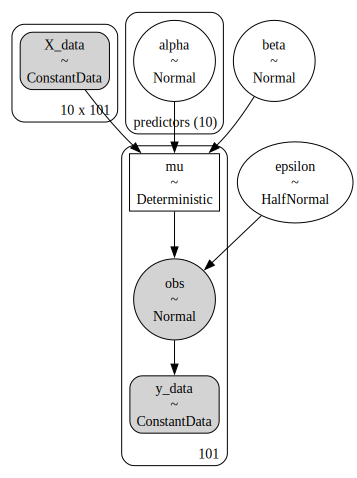

In [10]:
with pm.Model(coords={"predictors": columns}) as model1:
    X_data = pm.ConstantData("X_data", X.T)
    y_data = pm.ConstantData("y_data", y)

    alpha = pm.Normal("alpha", mu=0.0, sigma=10.0, dims="predictors")
    beta = pm.Normal("beta", mu=100.0, sigma=25.0)
    epsilon = pm.HalfNormal("epsilon", sigma=25.0)

    mu = pm.Deterministic("mu", alpha @ X_data + beta)

    obs = pm.Normal("obs", mu=mu, sigma=epsilon, observed=y_data)

g = pm.model_to_graphviz(model1)
display(g)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [alpha, beta, epsilon]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


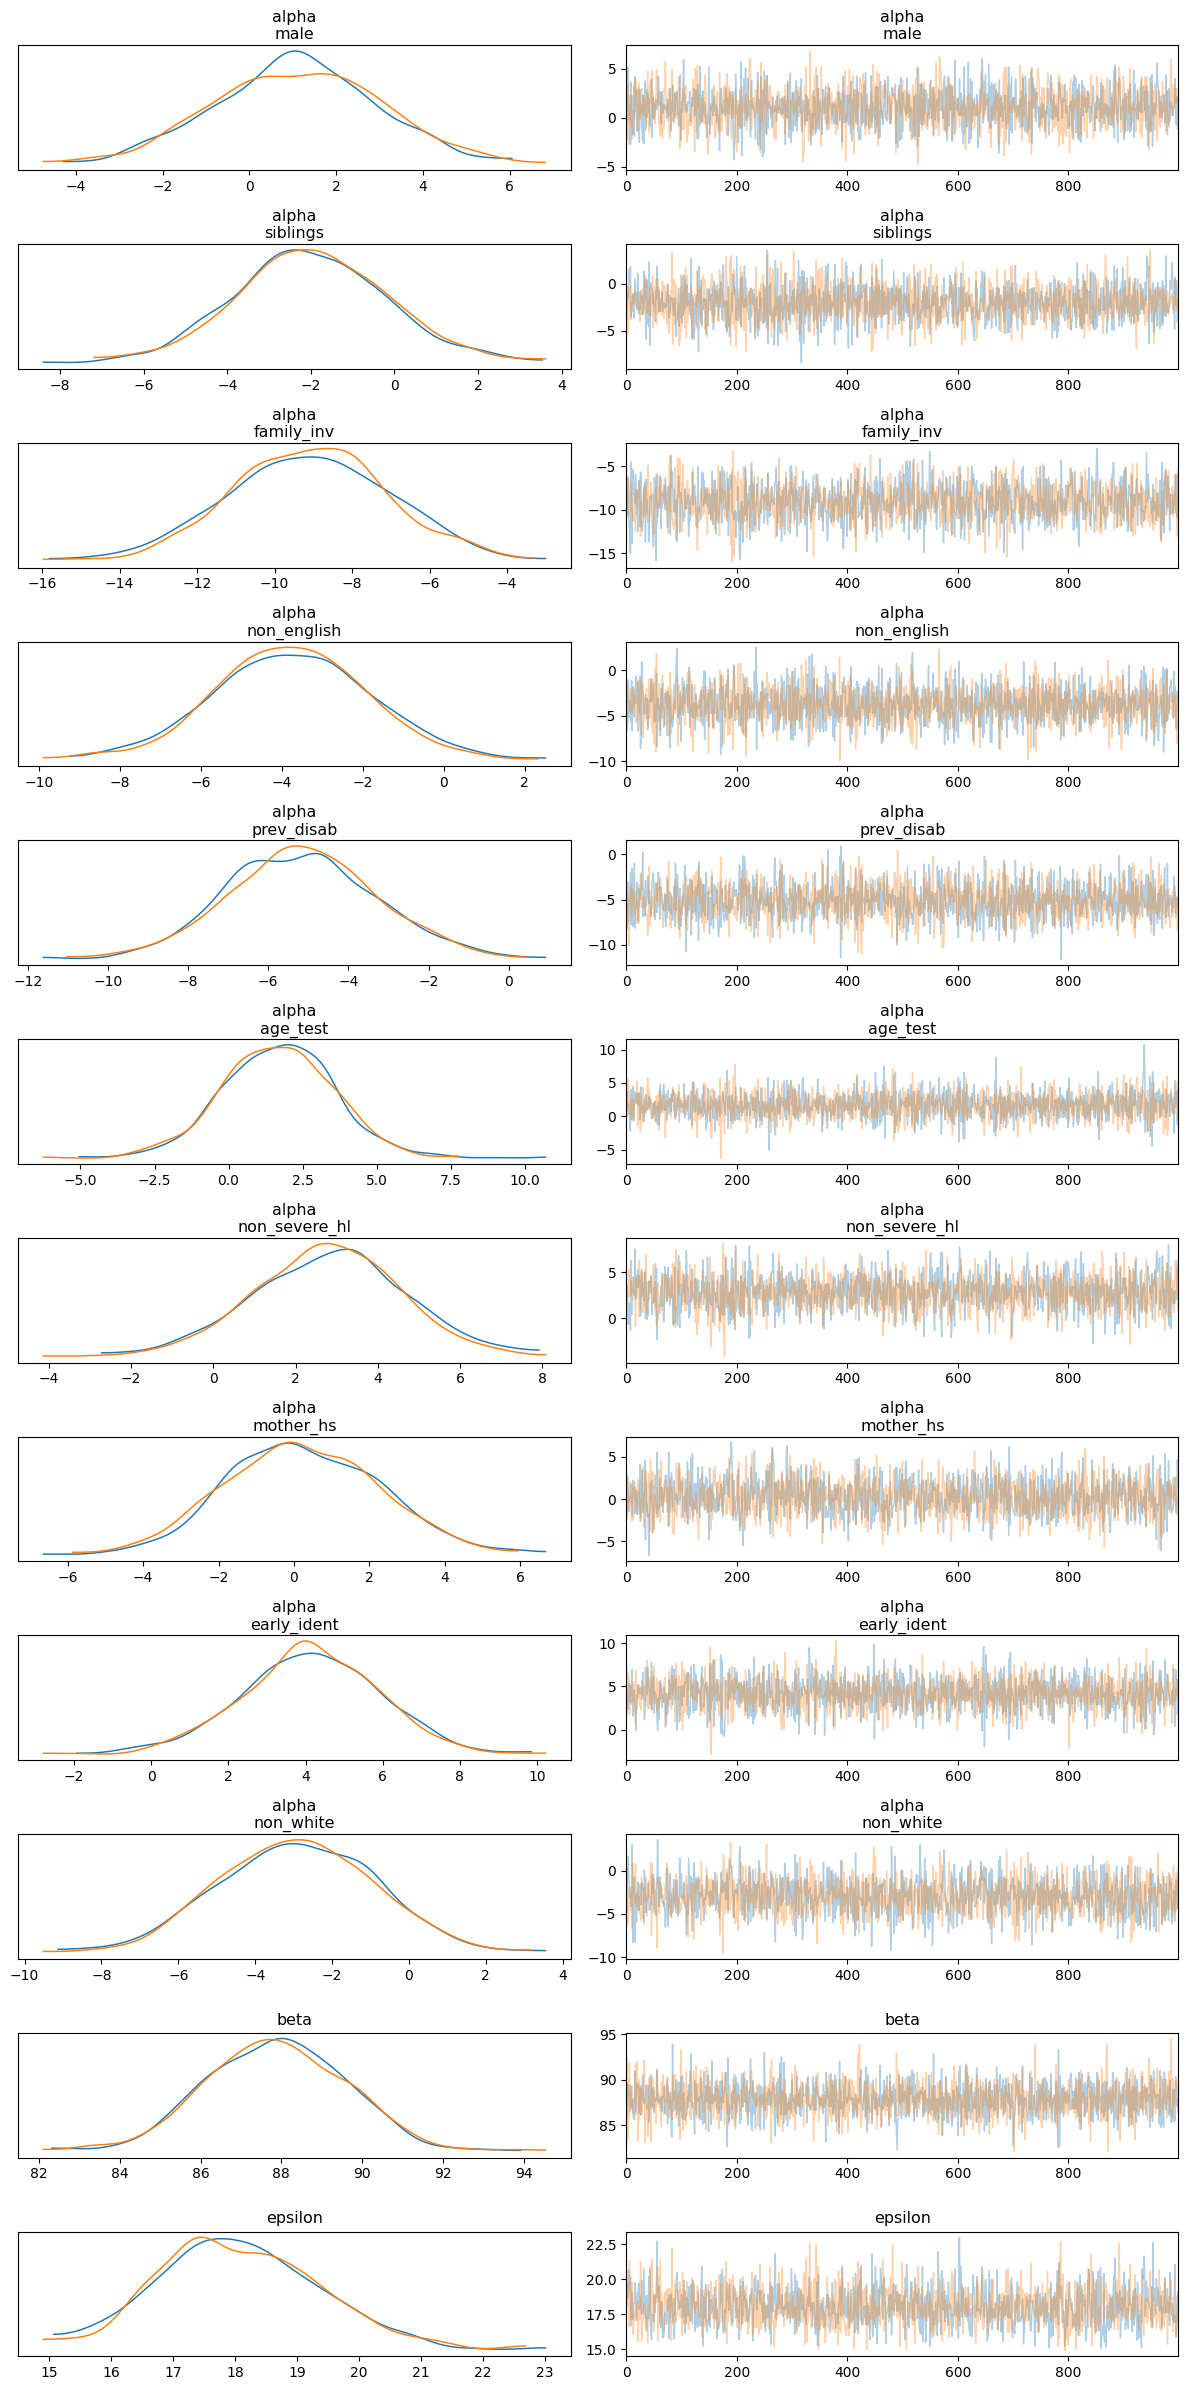

In [11]:
with model1:
    idata1 = pm.sample(random_seed=42, chains=2, target_accept=0.95)

az.plot_trace(idata1, var_names=["alpha", "beta", "epsilon"], compact=False)
plt.tight_layout()

In [12]:
summary1 = az.summary(idata1, var_names=["alpha"])
display(summary1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[male],1.080,1.881,-2.540,4.445,0.042,0.036,2020.0,1589.0,1.0
alpha[siblings],-1.992,1.820,-5.370,1.545,0.036,0.030,2494.0,1528.0,1.0
alpha[family_inv],-9.112,2.090,-12.807,-5.065,0.051,0.036,1676.0,1516.0,1.0
alpha[non_english],-3.767,1.926,-7.429,-0.099,0.037,0.028,2709.0,1668.0,1.0
alpha[prev_disab],-5.149,1.875,-8.649,-1.561,0.041,0.030,2104.0,1747.0,1.0
alpha[age_test],1.657,1.880,-2.123,4.978,0.039,0.037,2326.0,1412.0,1.0
alpha[non_severe_hl],2.793,1.818,-0.813,6.108,0.041,0.031,1970.0,1380.0,1.0
alpha[mother_hs],0.235,2.051,-3.557,4.090,0.049,0.040,1747.0,1612.0,1.0
alpha[early_ident],4.130,1.775,0.822,7.455,0.036,0.026,2412.0,1546.0,1.0
alpha[non_white],-2.919,2.018,-6.468,0.876,0.049,0.035,1684.0,1423.0,1.0


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

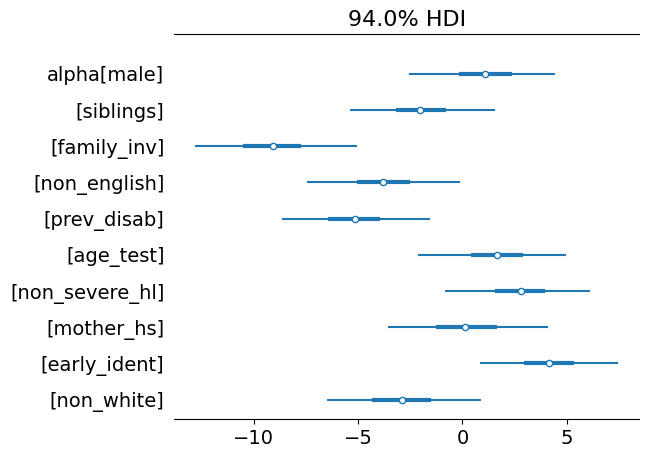

In [13]:
az.plot_forest(idata1, combined=True, var_names=["alpha"])

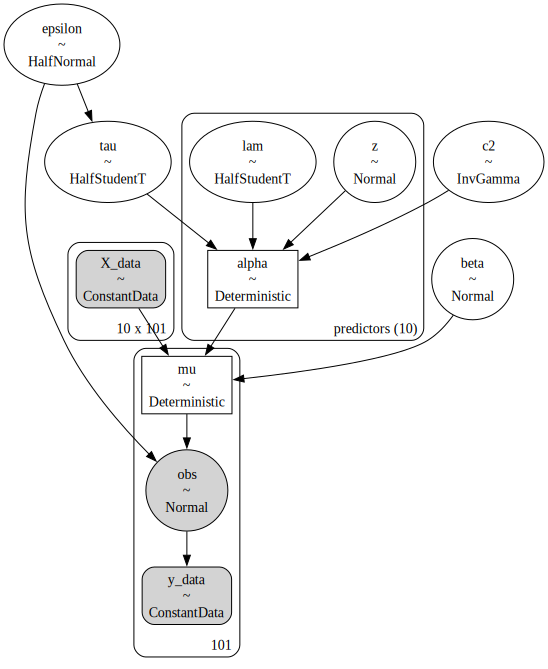

In [14]:
D0 = int(D / 2)

with pm.Model(coords={"predictors": columns}) as model2:
    X_data = pm.ConstantData("X_data", X.T)
    y_data = pm.ConstantData("y_data", y)

    # 誤差の分布
    epsilon = pm.HalfNormal("epsilon", sigma=25.0)

    # 事前分布の全体的な縮小
    tau = pm.HalfStudentT("tau", 2, D0 / (D - D0) * epsilon / np.sqrt(N))
    # 事前分布の局所的な縮小
    lam = pm.HalfStudentT("lam", 2, dims="predictors")
    c2 = pm.InverseGamma("c2", 1, 0.1)
    z = pm.Normal("z", 0.0, 1.0, dims="predictors")

    alpha = pm.Deterministic("alpha", z * tau * lam * pm.math.sqrt(c2 / (c2 + tau**2 * lam**2)), dims="predictors")
    beta = pm.Normal("beta", mu=100, sigma=25.0)
    
    mu = pm.Deterministic("mu", alpha @ X_data + beta)

    obs = pm.Normal("obs", mu, epsilon, observed=y_data)

g = pm.model_to_graphviz(model2)
display(g)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [epsilon, tau, lam, c2, z, beta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


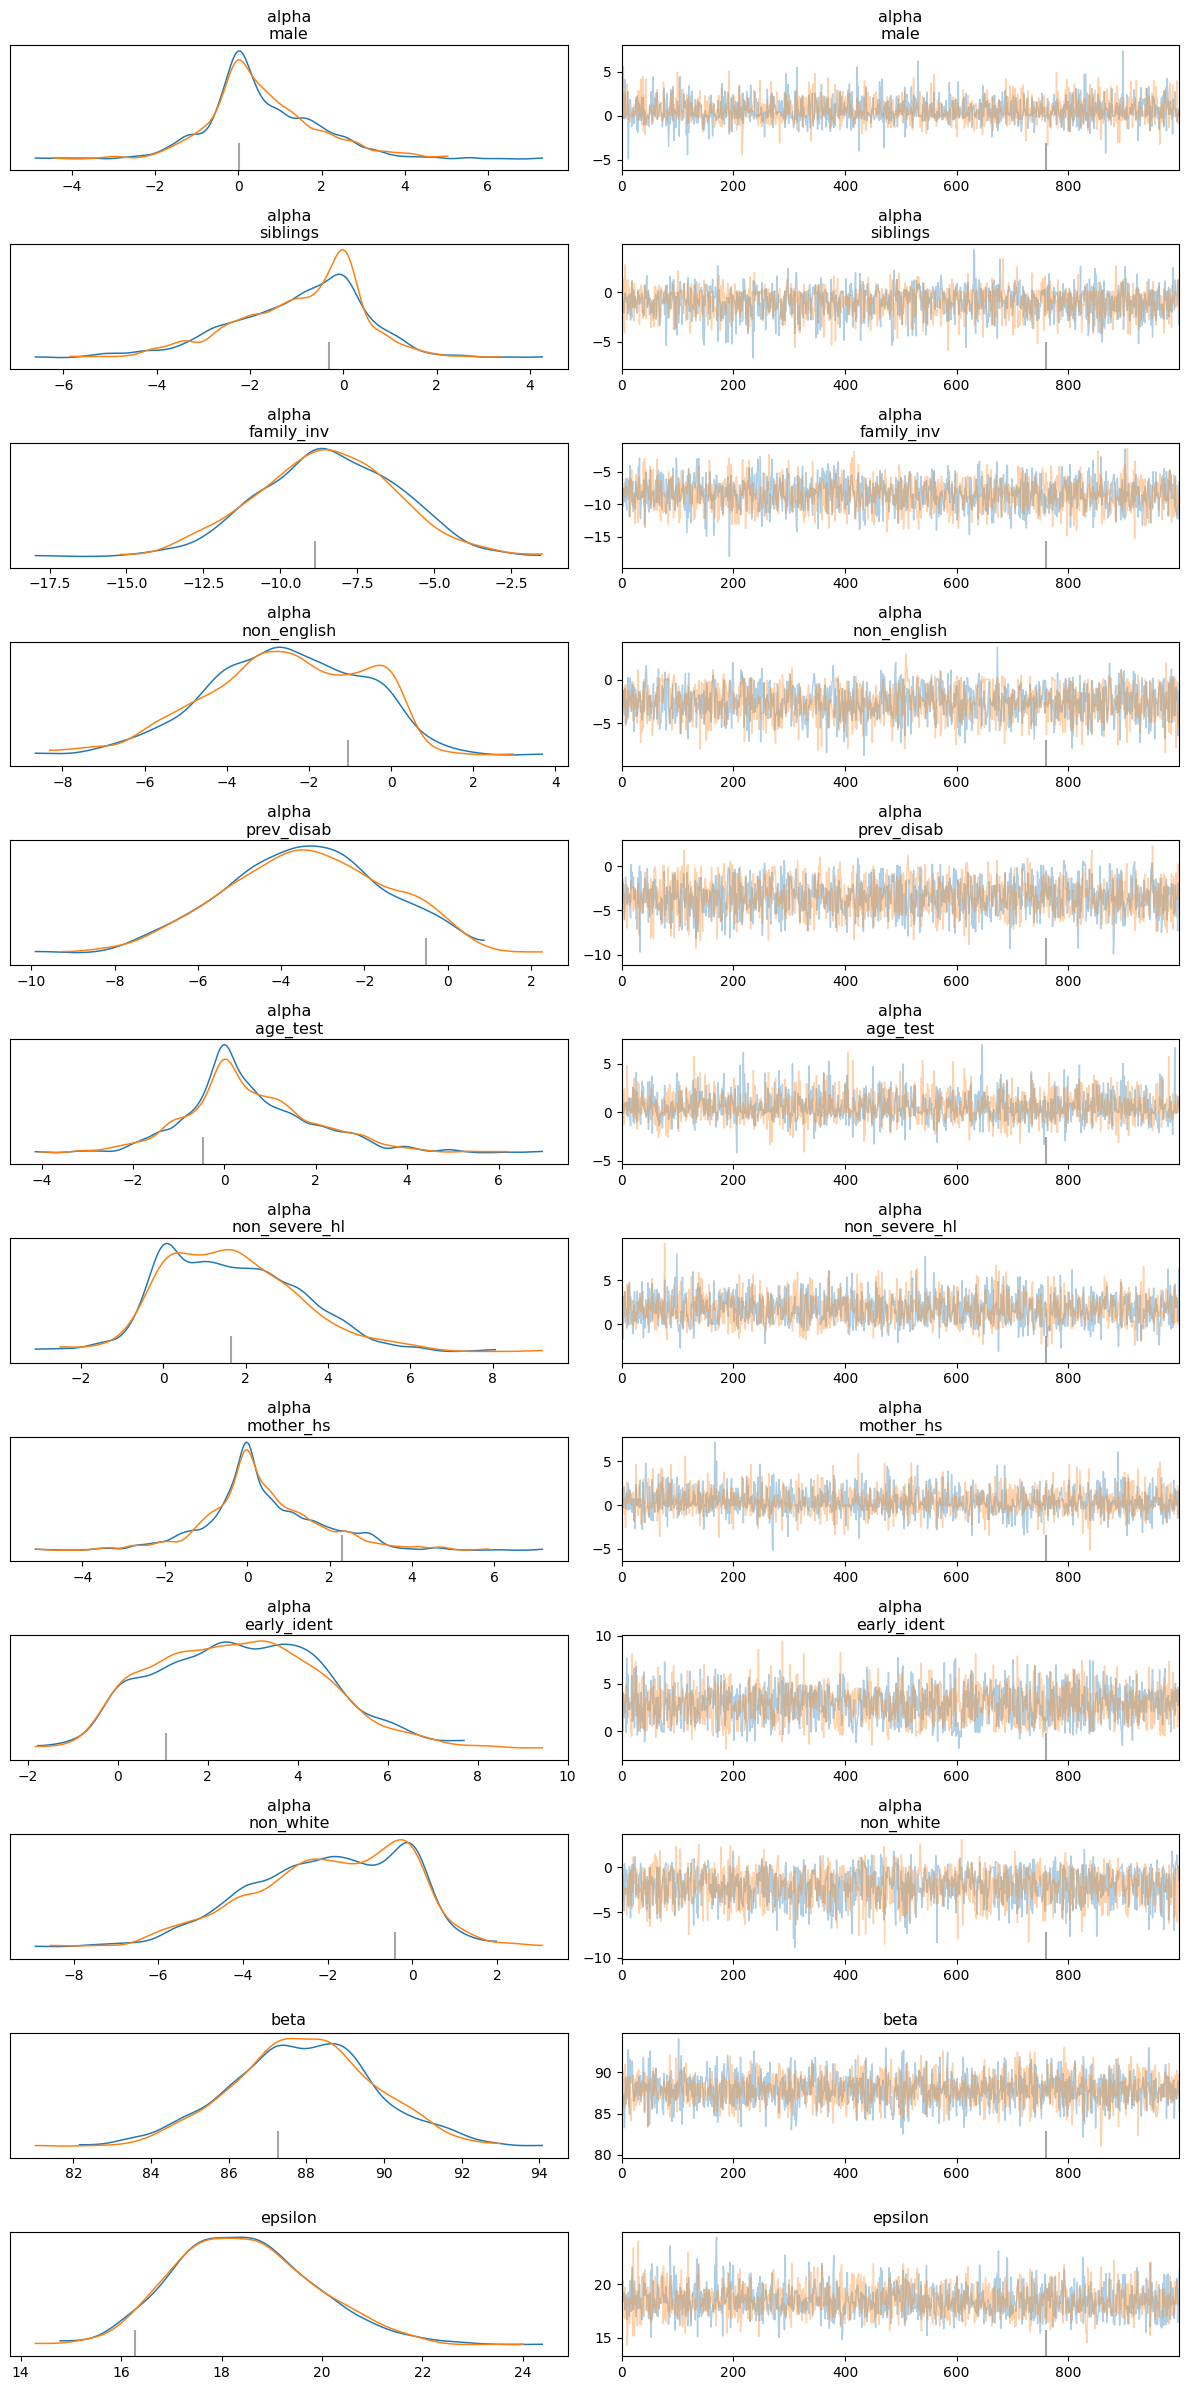

In [15]:
with model2:
    idata2 = pm.sample(random_seed=42, chains=2, target_accept=0.95)

az.plot_trace(idata2, var_names=["alpha", "beta", "epsilon"], compact=False)
plt.tight_layout();

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

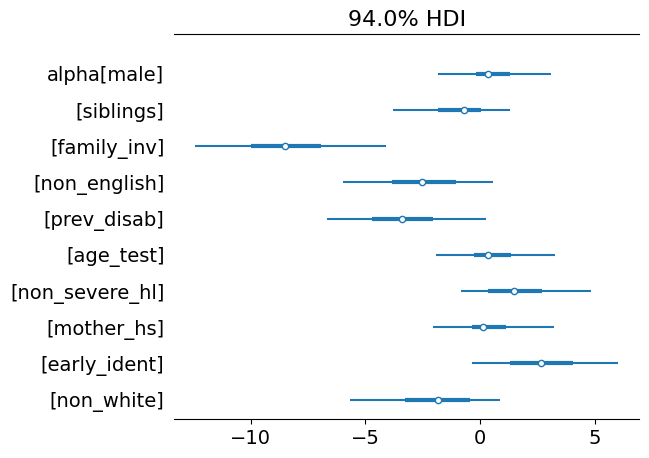

In [16]:
az.plot_forest(idata2, combined=True, var_names=["alpha"])